In [1]:
import geopandas as gpd
from shapely.geometry import Point, Polygon
import pandas as pd
import numpy as np
from fiona.drvsupport import supported_drivers
from simplekml import Kml, Color
supported_drivers['KML'] = 'rw'
supported_drivers['libkml'] = 'rw' # enable KML support which is disabled by default
supported_drivers['LIBKML'] = 'rw' # enable KML support which is disabled 
import numpy as np
import geopandas as gpd
from simplekml import Kml, Color
import os
import time
from geopy.distance import geodesic

In [2]:
def generate_bins(geom, bin_size=10):

    xmin, ymin, xmax, ymax = geom.bounds
    # Calculate the number of bins in each dimension
    xbins = int((xmax - xmin) / bin_size)
    ybins = int((ymax - ymin) / bin_size)
    # Create arrays of x and y coordinates for bins
    x_coords = np.arange(xmin, xmin + xbins * bin_size, bin_size)
    y_coords = np.arange(ymin, ymin + ybins * bin_size, bin_size)
    # Use NumPy's meshgrid to generate all combinations of x and y coordinates
    x_grid, y_grid = np.meshgrid(x_coords, y_coords)
    # Flatten the arrays and create bin polygons using vectorized operations
    x_flat = x_grid.flatten()
    y_flat = y_grid.flatten()
    bin_polygons = [
        Polygon([
            (x, y), (x + bin_size, y), (x + bin_size, y + bin_size), (x, y + bin_size)
        ]) for x, y in zip(x_flat, y_flat)
    ]
    return bin_polygons

In [3]:
## Get border file and raw data file
# area_name = "DN_KCN_AN_DON"
# area_name = "DN_KCN_HOA_KHANH"
area_name = "QN_KCN_VSIP"
# area_name = "KH_QL1"
date_str = '170723'
bin_size = 10

input_polygon_file = f"../Polygon/{area_name}.kml"
polygon_df = gpd.read_file(input_polygon_file)
          
input_raw_file = f"../Raw/{area_name}/{area_name}_{date_str}.csv"
df_raw = pd.read_csv(input_raw_file)

# folder_path = f"../Raw/{area_name}/Pilot_{date_str}"
# print(f"Reading from multiple input raw files in {folder_path}")
# df_list = []
# for filename in os.listdir(folder_path):
#     if filename.endswith('.csv'):
#         file_path = os.path.join(folder_path, filename)
#         df = pd.read_csv(file_path, low_memory=False)
#         df_list.append(df)
# df_raw = pd.concat(df_list, ignore_index=True)

C:\Users\MLMT-DATTH-P\AppData\Local\Temp\ipykernel_16596\2373620165.py:13: DtypeWarning: Columns (11,12,26,102,103,106,109) have mixed types. Specify dtype option on import or set low_memory=False.
  df_raw = pd.read_csv(input_raw_file)


In [4]:
## Divide bins and locate points

print(f"***===RUNNING:{area_name}, {bin_size}*{bin_size} grid ==***")
### Read a Polygon and divide
polygon_df = polygon_df.to_crs('EPSG:3857')
bins_polygons = [generate_bins(geom, bin_size) for geom in polygon_df['geometry']]
bins_polygons = [bin_poly for sublist in bins_polygons for bin_poly in sublist]
# Create the GeoDataFrame for bins
bins_df = gpd.GeoDataFrame({'geometry': bins_polygons}, crs=polygon_df.crs)
bins_df_4326 = bins_df.to_crs("EPSG:4326")
print('==Complete dividing bins')
### Load raw data file
df_point = df_raw.copy()
df_point_columns = [
    'Start Time',
    'eNodeB',
    'EARFCN (DL)',
    'EARFCN (UL)',
    'Physical Cell ID',
    'Latitude',
    'Longitude',
    'UL Volume (kB)',
    'DL Volume (kB)',
    'CQI 0',
    'CQI 1',
    'CQI 2',
    'CQI 3',
    'CQI 4',
    'CQI 5',
    'CQI 6',
    'CQI 7',
    'CQI 8',
    'CQI 9',
    'CQI 10',
    'CQI 11',
    'CQI 12',
    'CQI 13',
    'CQI 14',
    'CQI 15',
    'Serving Cell Label',
    'Serving Cell RSRP',
    'Best Cell Label',
    'Best Cell RSRP',
    'Second Best Cell Label',
    'Second Best Cell RSRP',
    'Third Best Cell Label',
    'Third Best Cell RSRP',
    'Fourth Best Cell Label',
    'Fourth Best Cell RSRP',
    'Fifth Best Cell Label',
    'Fifth Best Cell RSRP',
    'Sixth Best Cell Label',
    'Sixth Best Cell RSRP',
]
df_point = df_point[df_point_columns]

### Locate bins for each sample
bins_df_4326.reset_index(inplace=True)
polygonDF = bins_df_4326.copy()
polygonDF = polygonDF[['geometry']]
# Create Point Dataframe
geometric_points = []
for xy in zip(df_point['Longitude'], df_point['Latitude']):
    geometric_points.append(Point(xy))

pointDF = gpd.GeoDataFrame(df_point,
                                crs = {'init': 'epsg:4326'}, 
                                geometry = geometric_points
                                )
pointDF = pointDF.to_crs(polygonDF.crs)
# Join 2 DFs
joinDF = gpd.sjoin(pointDF,polygonDF, how='inner', predicate='within')
joinDF['polygon'] = joinDF['index_right'].map(polygonDF['geometry'])
print('==Complete Locating point')

### Preprocessing
df_segment = joinDF.copy()
df_segment = df_segment[df_segment['polygon'].notna()]
df_segment = df_segment.dropna(subset='Best Cell Label')
df_segment['polygon_str'] = df_segment['polygon'].astype(str)

***===RUNNING:QN_KCN_VSIP, 10*10 grid ==***
==Complete dividing bins


c:\Users\MLMT-DATTH-P\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


==Complete Locating point


In [5]:
## Pilot pollution
# Pilot Pollution
pilot_columns = [
    'polygon_str',
    'Serving Cell Label',
    'Serving Cell RSRP',
    'Best Cell Label',
    'Best Cell RSRP',
    'Second Best Cell Label',
    'Second Best Cell RSRP',
    'Third Best Cell Label',
    'Third Best Cell RSRP',
    'Fourth Best Cell Label',
    'Fourth Best Cell RSRP',
    'Fifth Best Cell Label',
    'Fifth Best Cell RSRP',
    'Sixth Best Cell Label',
    'Sixth Best Cell RSRP'
]
df_pilot = df_segment[pilot_columns]
df_pilot['rsrp_margin'] = df_pilot['Best Cell RSRP'] - 5
n_bestcell_clumns = [
    'rsrp_margin',
    'Second Best Cell RSRP',
    'Third Best Cell RSRP',
    'Fourth Best Cell RSRP',
    'Fifth Best Cell RSRP',
    'Sixth Best Cell RSRP'
]
compare_column = 'rsrp_margin'
df_pilot['pilot_polution'] = df_pilot[n_bestcell_clumns].apply(lambda row: sum(row[1:] > row[compare_column]), axis=1)
df_pilot_agg = df_pilot[['polygon_str', 'pilot_polution']].copy()
df_pilot_agg_mean = df_pilot_agg.groupby('polygon_str').mean()
df_pilot_agg_count = df_pilot_agg.groupby('polygon_str').count()
df_pilot_agg = df_pilot_agg_mean
df_pilot_agg['No.Samples'] = df_pilot_agg_count['pilot_polution']
df_pilot_agg.reset_index(inplace=True)

C:\Users\MLMT-DATTH-P\AppData\Local\Temp\ipykernel_16596\317385254.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pilot['rsrp_margin'] = df_pilot['Best Cell RSRP'] - 5
C:\Users\MLMT-DATTH-P\AppData\Local\Temp\ipykernel_16596\317385254.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pilot['pilot_polution'] = df_pilot[n_bestcell_clumns].apply(lambda row: sum(row[1:] > row[compare_column]), axis=1)


In [6]:
from pilot import save_output_to_kml
save_output_to_kml(df_pilot_agg.reset_index(drop=True), 'pilot_polution', 'pilot_pollution', 'pilot')

In [7]:
df = df_pilot_agg[df_pilot_agg['No.Samples'] >= 3]
df['polygon_str'] = df['polygon_str'].str.replace('POLYGON ', '', regex=False).str.replace('(', '', regex=False).str.replace(')', '', regex=False)
df['geometry'] = df['polygon_str'].apply(lambda x: Polygon([tuple(map(float, c.split())) for c in x.split(',')]))
gdf = gpd.GeoDataFrame(df, geometry='geometry')
gdf.crs = "epsg:4326"
gdf = gdf.to_crs('EPSG:3857')
gdf['center_point'] = gdf['geometry'].centroid
gdf['latitude'] = gdf['center_point'].y
gdf['longitude'] = gdf['center_point'].x
pilot_range = [-float('inf'), 1.33, float('inf')]
gdf['pilot'] = pd.cut(gdf['pilot_polution'], bins=pilot_range, labels=False)
gdf


C:\Users\MLMT-DATTH-P\AppData\Local\Temp\ipykernel_16596\144378955.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['polygon_str'] = df['polygon_str'].str.replace('POLYGON ', '', regex=False).str.replace('(', '', regex=False).str.replace(')', '', regex=False)
C:\Users\MLMT-DATTH-P\AppData\Local\Temp\ipykernel_16596\144378955.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['geometry'] = df['polygon_str'].apply(lambda x: Polygon([tuple(map(float, c.split())) for c in x.split(',')]))


,polygon_str,pilot_polution,No.Samples,geometry,center_point,latitude,longitude,pilot
6,"108.769742 15.210754, 108.769832 15.210754, 10...",0.500000,4,"POLYGON ((12108192.293 1713500.815, 12108202.3...",POINT (12108197.303 1713505.834),1.713506e+06,1.210820e+07,0
7,"108.769832 15.210754, 108.769922 15.210754, 10...",0.750000,4,"POLYGON ((12108202.312 1713500.815, 12108212.3...",POINT (12108207.321 1713505.834),1.713506e+06,1.210821e+07,0
12,"108.770191 15.210841, 108.770281 15.210841, 10...",1.000000,3,"POLYGON ((12108242.276 1713510.852, 12108252.2...",POINT (12108247.285 1713515.870),1.713516e+06,1.210825e+07,0
21,"108.771 15.211275, 108.77109 15.211275, 108.77...",1.000000,4,"POLYGON ((12108332.333 1713560.918, 12108342.3...",POINT (12108337.342 1713565.879),1.713566e+06,1.210834e+07,0
24,"108.77118 15.211015, 108.771269 15.211015, 108...",1.000000,4,"POLYGON ((12108352.371 1713530.925, 12108362.2...",POINT (12108357.324 1713535.885),1.713536e+06,1.210836e+07,0
...,...,...,...,...,...,...,...,...
17980,"108.806843 15.204773, 108.806933 15.204773, 10...",1.230769,13,"POLYGON ((12112322.358 1712810.852, 12112332.3...",POINT (12112327.367 1712815.870),1.712816e+06,1.211233e+07,0
17981,"108.806843 15.20486, 108.806933 15.20486, 108....",1.281250,32,"POLYGON ((12112322.358 1712820.888, 12112332.3...",POINT (12112327.367 1712825.906),1.712826e+06,1.211233e+07,0
17982,"108.806843 15.205293, 108.806933 15.205293, 10...",0.666667,3,"POLYGON ((12112322.358 1712870.838, 12112332.3...",POINT (12112327.367 1712875.856),1.712876e+06,1.211233e+07,0
17983,"108.806843 15.205553, 108.806933 15.205553, 10...",0.000000,4,"POLYGON ((12112322.358 1712900.831, 12112332.3...",POINT (12112327.367 1712905.849),1.712906e+06,1.211233e+07,0


c:\Users\MLMT-DATTH-P\AppData\Local\Programs\Python\Python311\Lib\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Text(0.5, 1.0, 'DBSCAN Clustering')

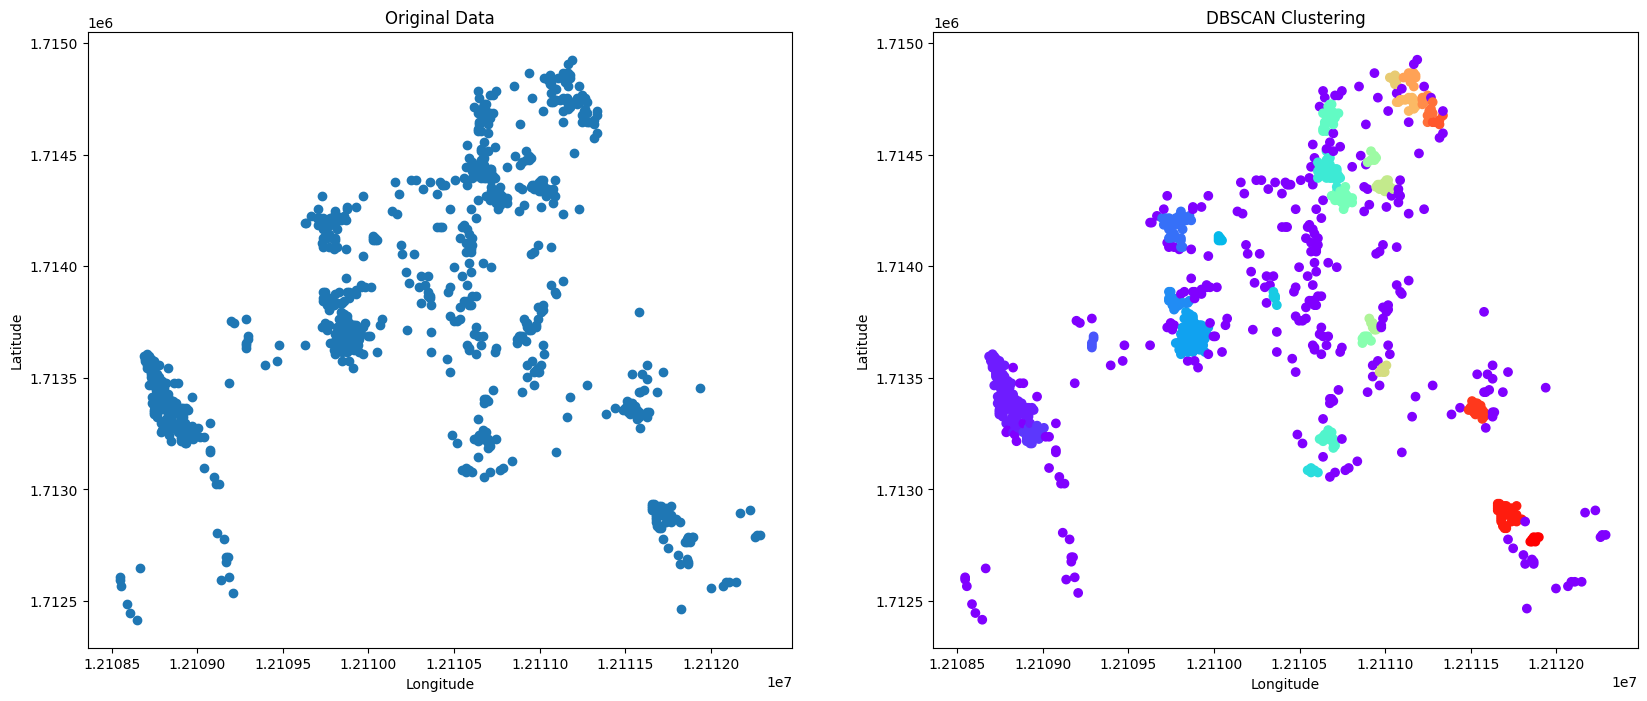

In [8]:
import pandas as pd
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# gdf[['longitude', 'latitude']] = scaler.fit_transform(gdf[['longitude', 'latitude']])
gdf = gdf[gdf['pilot'] == 1]
X = gdf[['longitude', 'latitude']]

# Create a DBSCAN model
eps =  35 # Epsilon (maximum distance between points in a cluster)
min_samples = 5  # Minimum number of samples to form a core point
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
# dbscan = DBSCAN()

# Fit the model to your data
labels = dbscan.fit_predict(X)

# Add cluster labels to the DataFrame
gdf['cluster'] = labels

# Plot the clusters
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)  # First subplot in a 2x2 grid
plt.scatter(gdf['longitude'], gdf['latitude'])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Original Data')

plt.subplot(1, 2, 2)  # Second subplot in a 2x2 grid
plt.scatter(gdf['longitude'], gdf['latitude'], c=labels, cmap='rainbow')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('DBSCAN Clustering')

In [9]:
from pilot import save_output_to_kml
save_output_to_kml(gdf.reset_index(drop=True), 'pilot_polution', 'pilot_pollution', 'test')

In [10]:
gdf1 = gdf[gdf['cluster'] != -1][['geometry','cluster']].to_crs('EPSG:4326')

In [11]:
import geopandas as gpd
import shapely.geometry as sg
import simplekml

# Initialize KML object
kml = simplekml.Kml()

# Group polygons by cluster
grouped = gdf1.groupby('cluster')

# Create polygons and outlines for each group
for cluster, group in grouped:
    # Combine the geometries of polygons in the same cluster
    combined_geometry = sg.MultiPolygon(list(group['geometry']))
    
    # Create a bounding box polygon around the combined geometry
    bounding_box = combined_geometry.envelope
    
    placemark = kml.newpolygon(
        outerboundaryis=list(bounding_box.exterior.coords),
        name=f'Cluster {cluster} Outline',
        altitudemode=simplekml.AltitudeMode.clamptoground,
    )

# Save the KML file
kml_file_path = 'cluster_outlines.kml'
kml.save(kml_file_path)
